## Analysis of the tumors dimensions

In [1]:
import pathlib as pt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
MASKS_PATH = pt.Path("D:\work\BreastTumorSegmentation\dataset\original_size\masks")

In [3]:
def get_dim_tumor(input_mask_path, show=False):
    input_mask = cv2.imread(str(input_mask_path), cv2.IMREAD_GRAYSCALE)
    white_area = cv2.findNonZero(input_mask)
    x, y, w, h = cv2.boundingRect(white_area)
    if show:
        print("[INFO] Bbox:", x, y, w, h)
        display_mask = cv2.cvtColor(input_mask, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(display_mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imwrite("bbox.jpg", display_mask)
        plt.imshow(display_mask)
    return x, y, w, h

In [4]:
def compute_tumor_stats(mask_list):
    dim = {"width": [], "height": []}
    for mask in tqdm(mask_list):
        _, _, w, h = get_dim_tumor(mask)
        dim["width"].append(w)
        dim["height"].append(h)
    
    tumor_dim = pd.DataFrame(data=dim)
    
    print(tumor_dim.describe())
    return tumor_dim

In [5]:
def plot_hist(tumor_dim, tumor_type, separated=False, save=False):
    if separated:
        # set up figure & axes
        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 3))
        tumor_dim.hist(ax=axes)
        plt.suptitle("Distribution of {} tumors".format(tumor_type))
        for ax in axes:
            ax.set_xlabel("Dimension")
            ax.set_ylabel("Frequency")
        if save:
            fig.savefig("Distribution_{}_tumors.jpg".format(tumor_type), bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.clf()
    else:
        df1x = tumor_dim["width"]
        df2x = tumor_dim["height"]
        #Stack the data
        fig = plt.figure()
        plt.hist([df1x, df2x], stacked=True)
        plt.title("Distribution of {} tumors".format(tumor_type), fontsize=16)
        plt.xlabel("Dimension", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.legend(["Width", "Height"])
        if save:
            fig.savefig("Distribution_{}_tumors.jpg".format(tumor_type), bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.clf()

### Histograms of tumor dimensions for each type

  0%|                                                                                 | 2/1696 [00:00<01:26, 19.51it/s]

[INFO] Found 1696 masks for MASS tumors


100%|██████████████████████████████████████████████████████████████████████████████| 1696/1696 [02:01<00:00, 13.93it/s]


             width       height
count  1696.000000  1696.000000
mean    335.885613   333.008255
std     135.622163   135.689999
min      64.000000    88.000000
25%     248.000000   240.000000
50%     312.000000   304.000000
75%     384.000000   384.000000
max    1368.000000  1336.000000


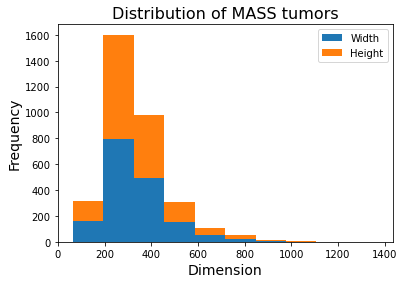

  0%|                                                                                 | 2/1872 [00:00<01:53, 16.53it/s]

[INFO] Found 1872 masks for CALC tumors


100%|██████████████████████████████████████████████████████████████████████████████| 1872/1872 [02:10<00:00, 14.35it/s]

             width       height
count  1872.000000  1872.000000
mean    439.042201   429.175214
std     420.832249   445.023156
min      40.000000    40.000000
25%     166.000000   160.000000
50%     296.000000   280.000000
75%     560.000000   528.000000
max    2880.000000  3808.000000


<Figure size 432x288 with 0 Axes>

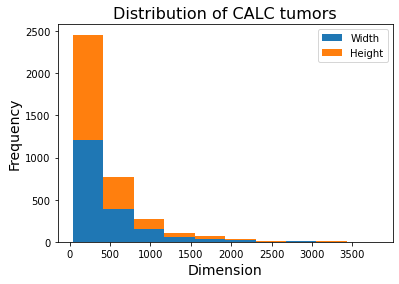

<Figure size 432x288 with 0 Axes>

In [7]:
tumor_type = ['MASS', 'CALC']
df_list = []
for _type in tumor_type:
    mask_list = list(MASKS_PATH.glob("{}*".format(_type)))
    print("[INFO] Found {} masks for {} tumors".format(len(mask_list), _type))
    _df = compute_tumor_stats(mask_list)
    _df["tumor_type"] = _type
    df_list.append(_df)
    plot_hist(_df, tumor_type=_type)

In [8]:
tumor_dim_df = pd.concat(df_list, sort=False).reset_index()
tumor_dim_df.head(2)

,index,width,height,tumor_type
0,0,400,488,MASS
1,1,224,256,MASS


In [9]:
tumor_dim_df = tumor_dim_df.drop(columns="index")
tumor_dim_df["tumor_type"].unique()

array(['MASS', 'CALC'], dtype=object)

### Scatter plot of tumor dimensions per type

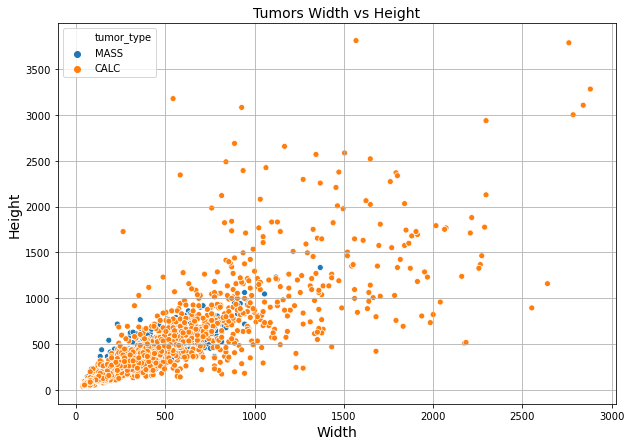

In [10]:
fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x="width", y="height", data=tumor_dim_df, hue="tumor_type")
ax.set_title("Tumors Width vs Height", fontsize=14)
ax.set_xlabel("Width", fontsize=14)
ax.set_ylabel("Height", fontsize=14)
ax.grid(True)

### Tumor area

In [12]:
tumor_dim_df["tumor_area"] = tumor_dim_df["width"] * tumor_dim_df["height"]

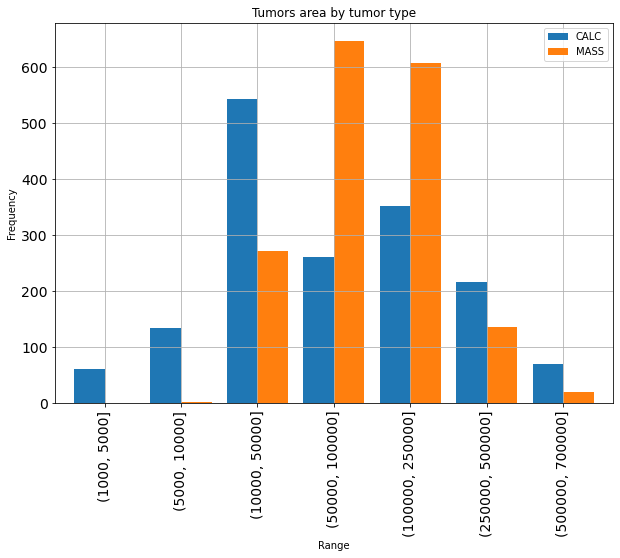

In [36]:
edges = [1000, 5000, 10000, 50000, 100000, 250000, 500000, 700000]
tumor_dim_df["group_area"] = ''
tumor_dim_df["group_area"] = pd.cut(tumor_dim_df["tumor_area"], bins=edges, duplicates='drop')
_grouped = tumor_dim_df[["tumor_type", "tumor_area", "group_area"]].groupby(["tumor_type", "group_area"]).count()
_grouped = _grouped.unstack(["tumor_type"])
ax = _grouped.plot(kind='bar', width=0.8, figsize=(10, 7), fontsize=14, grid=True)
ax.set_title("Tumors area by tumor type")
ax.set_xlabel("Range")
ax.set_ylabel("Frequency")
ax.legend(labels=[c[1] for c in _grouped.columns])